In [0]:
dbutils.library.restartPython()

In [0]:
# Imports
import pandas as pd
import numpy as np
import json
import io
import requests
from collections import Counter
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
print('✅ Imports loaded')

✅ Imports loaded


In [0]:
# Azure settings & Data Loading
import io
import requests

storage_account = 'lab94290'
container = 'airbnb'
sas_token = 'sp=rle&st=2025-12-24T17:37:04Z&se=2026-02-28T01:52:04Z&spr=https&sv=2024-11-04&sr=c&sig=a0lx%2BS6PuS%2FvJ9Tbt4NKdCJHLE9d1Y1D6vpE1WKFQtk%3D'
base_url = f'https://{storage_account}.blob.core.windows.net/{container}'

parquet_file = 'airbnb_1_12_parquet/part-00000-tid-1637687860512127859-6b9a9b3d-9a1b-4463-b4a9-bd5a0f7f348f-91-1-c000.snappy.parquet'
url = f'{base_url}/{parquet_file}?{sas_token}'

print('📥 Downloading data from Azure...')
response = requests.get(url)
df = pd.read_parquet(io.BytesIO(response.content))
print(f'✅ Data loaded: {len(df):,} rows, {len(df.columns)} columns')

📥 Downloading data from Azure...
✅ Data loaded: 216,065 rows, 50 columns


In [0]:
# Parse functions
def parse_reviews_text(reviews_str):
    if pd.isna(reviews_str): return []
    try:
        reviews = json.loads(reviews_str)
        return [r.replace('<br/>', ' ').strip() for r in reviews if r] if isinstance(reviews, list) else []
    except: return []

def parse_category_ratings(rating_str):
    if pd.isna(rating_str): return {}
    try:
        ratings = json.loads(rating_str) if isinstance(rating_str, str) else rating_str
        return {item['name']: float(item['value']) for item in ratings if 'name' in item} if isinstance(ratings, list) else {}
    except: return {}

def extract_host_id(seller_info):
    try:
        if pd.isna(seller_info): return 'unknown'
        data = json.loads(seller_info) if isinstance(seller_info, str) else seller_info
        return str(data.get('seller_id', 'unknown'))
    except: return 'unknown'

# Process
df_sample = df.sample(n=min(30000, len(df)), random_state=42).copy()
df_sample['host_id'] = df_sample['seller_info'].apply(extract_host_id)
df_sample['reviews_list'] = df_sample['reviews'].apply(parse_reviews_text)
df_sample['ratings_dict'] = df_sample['category_rating'].apply(parse_category_ratings)
df_sample['cleanliness_rating'] = df_sample['ratings_dict'].apply(lambda x: x.get('Cleanliness'))
df_sample['accuracy_rating'] = df_sample['ratings_dict'].apply(lambda x: x.get('Accuracy'))
df_sample['checkin_rating'] = df_sample['ratings_dict'].apply(lambda x: x.get('Check-in'))
df_sample['communication_rating'] = df_sample['ratings_dict'].apply(lambda x: x.get('Communication'))
df_sample['location_rating'] = df_sample['ratings_dict'].apply(lambda x: x.get('Location'))
df_sample['value_rating'] = df_sample['ratings_dict'].apply(lambda x: x.get('Value'))
df_sample['review_count'] = df_sample['reviews_list'].apply(len)

# Filter to target locations
target_locations = pd.read_csv('scraped_cities.csv')
target_cities = set(target_locations['city'].str.lower().str.strip().tolist())

def matches_target_location(row):
    loc = str(row.get('location', '')).lower() if pd.notna(row.get('location')) else ""
    for city in target_cities:
        if city in loc:
            return True
    return False

df_filtered = df_sample[df_sample.apply(matches_target_location, axis=1)].copy()

# Explode reviews
reviews_exploded = df_filtered[df_filtered['review_count'] > 0][[
    'property_id', 'listing_name', 'host_id', 'location',
    'reviews_list', 'cleanliness_rating', 'accuracy_rating', 'checkin_rating',
    'communication_rating', 'location_rating', 'value_rating'
]].explode('reviews_list').reset_index(drop=True)
reviews_exploded = reviews_exploded.rename(columns={'reviews_list': 'review_text'})
reviews_exploded = reviews_exploded[reviews_exploded['review_text'].notna() & (reviews_exploded['review_text'].str.len() > 10)].reset_index(drop=True)
reviews_exploded['review_id'] = range(len(reviews_exploded))

print(f'✅ Ready: {len(reviews_exploded):,} reviews from {reviews_exploded["host_id"].nunique():,} hosts')

✅ Ready: 183,425 reviews from 11,312 hosts


In [0]:
# ============================================
# LOAD LIGHTWEIGHT SENTIMENT MODEL
# ============================================
from transformers import pipeline

print("📦 Loading sentiment model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1,  # CPU
    truncation=True,
    max_length=256  # Shorter to save memory
)
print("✅ Model loaded!")

2026-01-29 11:27:35.669937: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-29 11:27:35.830184: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-29 11:27:36.457530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-29 11:27:41.861701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


📦 Loading sentiment model...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

✅ Model loaded!


In [0]:
# ============================================
# SENTIMENT ANALYSIS - MEMORY SAFE VERSION
# ============================================
from tqdm import tqdm
import gc

def analyze_sentiment_safe(texts, batch_size=32):
    """Analyze sentiment with memory management"""
    results = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing"):
        batch = [str(t)[:256] for t in texts[i:i+batch_size]]  # Truncate
        
        try:
            batch_results = sentiment_analyzer(batch)
            for r in batch_results:
                score = r['score'] if r['label'] == 'POSITIVE' else -r['score']
                results.append({'label': r['label'], 'score': round(score, 4)})
        except:
            for _ in batch:
                results.append({'label': 'NEUTRAL', 'score': 0.0})
        
        # Clear memory every 1000 batches
        if (i // batch_size) % 1000 == 0:
            gc.collect()
    
    return results

# Run on ALL 106k reviews (smaller batches = less memory)
print(f"🔄 Analyzing {len(reviews_exploded):,} reviews...")


results = analyze_sentiment_safe(reviews_exploded['review_text'].tolist(), batch_size=32)

reviews_exploded['sentiment_label'] = [r['label'] for r in results]
reviews_exploded['sentiment_score'] = [r['score'] for r in results]

print(f"\n✅ Done!")
print(reviews_exploded['sentiment_label'].value_counts())

🔄 Analyzing 183,425 reviews...
   Estimated time: ~15-20 minutes



Analyzing:   7%|▋    

*** WARNING: max output size exceeded, skipping output. ***

Analyzing: 100%|██████████| 5733/5733 [2:44:06<00:00,  1.72s/it]



✅ Done!
POSITIVE    171404
NEGATIVE     12021
Name: sentiment_label, dtype: int64


In [0]:

from collections import Counter
import re



ISSUE_PATTERNS = {
    # ============ NEGATIVE ISSUES ============
    # WiFi & Tech
    "wifi_issues": [r"\bwifi slow\b", r"\bwifi didn'?t work\b", r"\bno wifi\b", r"\binternet slow\b", r"\bwifi bad\b", r"\bweak wifi\b", r"\bwifi issues\b", r"\bwifi keeps disconnecting\b", r"\bno internet\b", r"\bpoor wifi\b"],
    "tv_issues": [r"\btv didn'?t work\b", r"\bno tv\b", r"\btv broken\b", r"\bcouldn'?t use tv\b", r"\bnetflix didn'?t work\b"],
    
    # Cleanliness
    "dirty_general": [r"\bdirty\b", r"\bnot clean\b", r"\bunclean\b", r"\bfilthy\b", r"\bdusty\b", r"\bneeds cleaning\b", r"\bwasn'?t clean\b"],
    "dirty_bathroom": [r"\bdirty bathroom\b", r"\bbathroom not clean\b", r"\bmold\b", r"\bmildew\b", r"\btoilet dirty\b", r"\bshower dirty\b"],
    "dirty_kitchen": [r"\bdirty kitchen\b", r"\bdirty dishes\b", r"\bkitchen not clean\b", r"\bgreasy\b"],
    "dirty_bedding": [r"\bdirty sheets\b", r"\bstained sheets\b", r"\bdirty towels\b", r"\bstained towels\b", r"\bdirty pillows\b"],
    "bugs_pests": [r"\bbugs\b", r"\binsects\b", r"\bants\b", r"\bcockroach", r"\broaches\b", r"\bspiders\b", r"\bmosquito", r"\bmice\b", r"\brats\b", r"\bbed bugs\b", r"\bflies\b"],
    "smell_issues": [r"\bbad smell\b", r"\bsmelled bad\b", r"\bodor\b", r"\bmusty\b", r"\bsmoke smell\b", r"\bsmelly\b", r"\bstinky\b", r"\bcigarette smell\b", r"\bmold smell\b"],
    "hair_found": [r"\bhair everywhere\b", r"\bfound hair\b", r"\bhair in bathroom\b", r"\bhair on sheets\b"],
    
    # Noise
    "noise_street": [r"\bstreet noise\b", r"\btraffic noise\b", r"\bnoisy street\b", r"\bloud traffic\b", r"\bcars outside\b"],
    "noise_neighbors": [r"\bloud neighbors\b", r"\bnoisy neighbors\b", r"\bneighbor noise\b", r"\bthin walls\b", r"\bcould hear neighbors\b", r"\bpeople upstairs\b"],
    "noise_general": [r"\bnoisy\b", r"\btoo loud\b", r"\bcouldn'?t sleep.{0,20}noise\b", r"\bnot quiet\b"],
    "noise_inside": [r"\bloud ac\b", r"\bnoisy appliances\b", r"\bloud fridge\b", r"\bnoisy pipes\b"],
    
    # Temperature & Comfort
    "too_hot": [r"\btoo hot\b", r"\bno ac\b", r"\bac didn'?t work\b", r"\bac broken\b", r"\bno air conditioning\b", r"\bsweltering\b", r"\bno fan\b"],
    "too_cold": [r"\btoo cold\b", r"\bno heating\b", r"\bfreezing\b", r"\bheater broken\b", r"\bno heat\b", r"\bcold at night\b"],
    "uncomfortable_bed": [r"\buncomfortable bed\b", r"\bbad mattress\b", r"\bhard mattress\b", r"\bsoft mattress\b", r"\blumpy mattress\b", r"\bbed too small\b", r"\bback hurt\b"],
    "uncomfortable_pillows": [r"\bbad pillows\b", r"\bflat pillows\b", r"\buncomfortable pillows\b", r"\bno pillows\b"],
    
    # Water & Plumbing
    "hot_water_issues": [r"\bno hot water\b", r"\bcold water only\b", r"\bwater pressure low\b", r"\bhot water ran out\b", r"\bwater not hot\b"],
    "plumbing_issues": [r"\btoilet broken\b", r"\btoilet wouldn'?t flush\b", r"\bclogged drain\b", r"\bsink clogged\b", r"\bleaking\b", r"\bleak\b", r"\bdripping\b"],
    "shower_issues": [r"\bshower didn'?t work\b", r"\bweak shower\b", r"\bshower broken\b", r"\bno water pressure\b"],
    
    # Check-in & Access
    "checkin_problems": [r"\bcheck-?in problem\b", r"\bcheck-?in difficult\b", r"\bcouldn'?t check in\b", r"\blate check-?in\b", r"\bearly check-?in denied\b"],
    "hard_to_find": [r"\bhard to find\b", r"\bcouldn'?t find\b", r"\bwrong address\b", r"\bconfusing directions\b", r"\bgot lost\b", r"\bno signs\b"],
    "key_issues": [r"\bkey didn'?t work\b", r"\blockbox problem\b", r"\bcouldn'?t get in\b", r"\blocked out\b", r"\bwrong code\b", r"\bkey broken\b"],
    "parking_issues": [r"\bno parking\b", r"\bparking difficult\b", r"\bparking far\b", r"\bcouldn'?t park\b", r"\bparking expensive\b"],
    
    # Host & Communication
    "host_unresponsive": [r"\bhost didn'?t respond\b", r"\bno response\b", r"\bslow response\b", r"\bcouldn'?t reach host\b", r"\bhost unavailable\b", r"\bignored messages\b"],
    "host_rude": [r"\bhost rude\b", r"\bhost unfriendly\b", r"\bhost unhelpful\b", r"\bbad host\b", r"\bterrible host\b"],
    "wrong_expectations": [r"\bnot as described\b", r"\bphotos misleading\b", r"\bdifferent from photos\b", r"\bfalse advertising\b", r"\bnot what expected\b", r"\bsmaller than photos\b"],
    
    # Value & Price
    "overpriced": [r"\boverpriced\b", r"\btoo expensive\b", r"\bnot worth the price\b", r"\bexpensive for what\b", r"\brip off\b", r"\bwaste of money\b"],
    "hidden_fees": [r"\bhidden fees\b", r"\bextra charges\b", r"\bsurprise fees\b", r"\bcleaning fee too high\b"],
    
    # Safety & Security
    "safety_concerns": [r"\bdidn'?t feel safe\b", r"\bunsafe\b", r"\bsketchy area\b", r"\bdangerous neighborhood\b", r"\bsecurity concerns\b"],
    "broken_lock": [r"\block broken\b", r"\bdoor didn'?t lock\b", r"\bno lock\b", r"\bsecurity issue\b"],
    
    # Amenities Missing
    "missing_amenities": [r"\bno towels\b", r"\bno toilet paper\b", r"\bno soap\b", r"\bno shampoo\b", r"\bnothing provided\b"],
    "kitchen_issues": [r"\bno cooking supplies\b", r"\bno pots\b", r"\bno pans\b", r"\bkitchen not equipped\b", r"\bno utensils\b", r"\bno dishes\b"],
    "laundry_issues": [r"\bwasher broken\b", r"\bdryer broken\b", r"\bno laundry\b", r"\bwashing machine didn'?t work\b"],
    
    # Space Issues
    "too_small": [r"\btoo small\b", r"\btiny\b", r"\bcramped\b", r"\bsmaller than expected\b", r"\bno space\b"],
    "stairs_access": [r"\btoo many stairs\b", r"\bno elevator\b", r"\bhard to access\b", r"\bnot accessible\b"],
    
    # ============ POSITIVE THEMES ============
    # Location
    "great_location": [r"\bgreat location\b", r"\bperfect location\b", r"\bamazing location\b", r"\bbest location\b", r"\bideal location\b", r"\bexcellent location\b", r"\bfantastic location\b", r"\bprime location\b"],
    "walkable": [r"\bwalking distance\b", r"\bwalkable\b", r"\bclose to everything\b", r"\bsteps away\b", r"\beasy walk\b", r"\bwalk to\b"],
    "near_transport": [r"\bnear metro\b", r"\bnear subway\b", r"\bnear bus\b", r"\bclose to train\b", r"\beasy transport\b", r"\bpublic transport\b"],
    "quiet_area": [r"\bquiet area\b", r"\bpeaceful\b", r"\bquiet neighborhood\b", r"\bquiet street\b", r"\bvery quiet\b", r"\btranquil\b"],
    "central": [r"\bcentral location\b", r"\bin the center\b", r"\bheart of the city\b", r"\bdowntown\b", r"\bcity center\b"],
    "good_neighborhood": [r"\bnice neighborhood\b", r"\bgreat neighborhood\b", r"\bsafe neighborhood\b", r"\blovely area\b", r"\bnice area\b", r"\bbeautiful neighborhood\b"],
    
    # Cleanliness
    "very_clean": [r"\bvery clean\b", r"\bspotless\b", r"\bimmaculate\b", r"\bsuper clean\b", r"\bsparkling clean\b", r"\bextremely clean\b", r"\bperfectly clean\b", r"\bpristine\b"],
    
    # Host
    "helpful_host": [r"\bhelpful host\b", r"\bhost was helpful\b", r"\bhost helped\b", r"\baccommodating host\b", r"\bhost went above\b"],
    "great_host": [r"\bgreat host\b", r"\bamazing host\b", r"\bwonderful host\b", r"\bbest host\b", r"\bfantastic host\b", r"\blovely host\b", r"\bexcellent host\b"],
    "responsive_host": [r"\bresponsive host\b", r"\bquick response\b", r"\bfast response\b", r"\bresponded quickly\b", r"\bquick to respond\b", r"\bimmediate response\b", r"\balways available\b"],
    "friendly_host": [r"\bfriendly host\b", r"\bwelcoming host\b", r"\bwarm welcome\b", r"\bhost was friendly\b", r"\bhost was kind\b", r"\bgracious host\b"],
    "great_communication": [r"\bgreat communication\b", r"\beasy communication\b", r"\bclear communication\b", r"\bgood communication\b", r"\bexcellent communication\b"],
    
    # Views & Aesthetics
    "great_view": [r"\bgreat view\b", r"\bamazing view\b", r"\bbeautiful view\b", r"\bstunning view\b", r"\bincredible view\b", r"\bgorgeous view\b", r"\bwonderful view\b", r"\bocean view\b", r"\bcity view\b", r"\bmountain view\b"],
    "beautiful_place": [r"\bbeautiful place\b", r"\bgorgeous\b", r"\bstunning\b", r"\blovely decor\b", r"\bbeautifully decorated\b", r"\bstylish\b", r"\bcharming\b"],
    
    # Value
    "good_value": [r"\bgreat value\b", r"\bgood value\b", r"\bworth the price\b", r"\bgood price\b", r"\bexcellent value\b", r"\bfair price\b", r"\breasonable price\b", r"\baffordable\b", r"\bworth every penny\b", r"\bgreat deal\b"],
    
    # Amenities
    "well_equipped": [r"\bwell equipped\b", r"\bhad everything\b", r"\bfully equipped\b", r"\ball amenities\b", r"\beverything we needed\b", r"\bfully stocked\b", r"\bwell stocked\b"],
    "great_kitchen": [r"\bgreat kitchen\b", r"\bfull kitchen\b", r"\bwell equipped kitchen\b", r"\bloved the kitchen\b", r"\bkitchen had everything\b"],
    "nice_bathroom": [r"\bnice bathroom\b", r"\bgreat bathroom\b", r"\bbeautiful bathroom\b", r"\bclean bathroom\b", r"\bmodern bathroom\b", r"\bspacious bathroom\b"],
    "good_wifi": [r"\bfast wifi\b", r"\bgreat wifi\b", r"\bwifi worked\b", r"\bstrong wifi\b", r"\bgood internet\b", r"\bexcellent wifi\b"],
    "good_bed": [r"\bcomfortable bed\b", r"\bgreat bed\b", r"\bslept well\b", r"\bcomfy bed\b", r"\bgood mattress\b", r"\bbest sleep\b"],
    "good_shower": [r"\bgreat shower\b", r"\bamazing shower\b", r"\bgood water pressure\b", r"\bhot shower\b", r"\bnice shower\b"],
    "pool_great": [r"\bgreat pool\b", r"\bloved the pool\b", r"\bnice pool\b", r"\bbeautiful pool\b", r"\bpool was perfect\b"],
    "good_ac": [r"\bac worked great\b", r"\bgood ac\b", r"\bnice and cool\b", r"\bac was perfect\b", r"\bgood air conditioning\b"],
    
    # Comfort
    "very_comfortable": [r"\bvery comfortable\b", r"\bsuper comfortable\b", r"\bextremely comfortable\b", r"\bso comfortable\b", r"\bcozy\b", r"\bhomey\b", r"\bfelt like home\b"],
    "spacious": [r"\bspacious\b", r"\blots of space\b", r"\bplenty of room\b", r"\broomy\b", r"\bbig apartment\b", r"\blarge space\b"],
    
    # Experience
    "will_return": [r"\bwill be back\b", r"\bcome back\b", r"\breturn\b", r"\bstay again\b", r"\bbook again\b", r"\bvisit again\b", r"\bdefinitely return\b"],
    "highly_recommend": [r"\bhighly recommend\b", r"\bdefinitely recommend\b", r"\bwould recommend\b", r"\bstrongly recommend\b", r"\bmust stay\b", r"\bdon'?t hesitate\b"],
    "exceeded_expectations": [r"\bexceeded expectations\b", r"\bbetter than expected\b", r"\babove and beyond\b", r"\bblown away\b", r"\bpleasantly surprised\b"],
    "perfect_stay": [r"\bperfect stay\b", r"\bamazing stay\b", r"\bwonderful stay\b", r"\bfantastic stay\b", r"\bincredible stay\b", r"\bbest stay\b", r"\bloved our stay\b"],
    
    # Check-in
    "easy_checkin": [r"\beasy check-?in\b", r"\bsmooth check-?in\b", r"\bsimple check-?in\b", r"\bself check-?in\b", r"\bseamless check-?in\b"],
    "good_instructions": [r"\bclear instructions\b", r"\bgood directions\b", r"\beasy to find\b", r"\bwell explained\b", r"\bdetailed instructions\b"],
    
    # Family/Groups
    "family_friendly": [r"\bgreat for families\b", r"\bkids loved\b", r"\bfamily friendly\b", r"\bperfect for kids\b", r"\bgreat for children\b"],
    "good_for_groups": [r"\bgreat for groups\b", r"\bperfect for group\b", r"\bfit everyone\b", r"\benough space for everyone\b"]
}

# List of negative themes
NEGATIVE_THEMES = [
    "wifi_issues", "tv_issues", "dirty_general", "dirty_bathroom", "dirty_kitchen", 
    "dirty_bedding", "bugs_pests", "smell_issues", "hair_found", "noise_street",
    "noise_neighbors", "noise_general", "noise_inside", "too_hot", "too_cold",
    "uncomfortable_bed", "uncomfortable_pillows", "hot_water_issues", "plumbing_issues",
    "shower_issues", "checkin_problems", "hard_to_find", "key_issues", "parking_issues",
    "host_unresponsive", "host_rude", "wrong_expectations", "overpriced", "hidden_fees",
    "safety_concerns", "broken_lock", "missing_amenities", "kitchen_issues", 
    "laundry_issues", "too_small", "stairs_access"
]

def extract_themes_regex(text):
    """Extract themes using regex word boundaries"""
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found = []
    for theme, patterns in ISSUE_PATTERNS.items():
        for pattern in patterns:
            if re.search(pattern, text_lower):
                found.append(theme)
                break
    return found

# Re-apply to all reviews
print("🔍 Extracting themes with fixed patterns...")
reviews_exploded['themes'] = reviews_exploded['review_text'].apply(extract_themes_regex)
reviews_exploded['theme_count'] = reviews_exploded['themes'].apply(len)

reviews_exploded['negative_themes'] = reviews_exploded['themes'].apply(
    lambda x: [t for t in x if t in NEGATIVE_THEMES]
)
reviews_exploded['positive_themes'] = reviews_exploded['themes'].apply(
    lambda x: [t for t in x if t not in NEGATIVE_THEMES]
)

# Summary
all_themes = [t for themes in reviews_exploded['themes'] for t in themes]
theme_counts = Counter(all_themes)

print(f"\n✅ Theme extraction complete!")
print(f"\n📊 TOP POSITIVE THEMES:")
for theme, count in theme_counts.most_common(50):
    if theme not in NEGATIVE_THEMES:
        print(f"   ✅ {theme}: {count:,}")

print(f"\n📊 TOP NEGATIVE THEMES (Issues):")
for theme, count in theme_counts.most_common(50):
    if theme in NEGATIVE_THEMES:
        print(f"   ❌ {theme}: {count:,}")

🔍 Extracting themes with fixed patterns...

✅ Theme extraction complete!

📊 TOP POSITIVE THEMES:
   ✅ will_return: 22,060
   ✅ highly_recommend: 20,601
   ✅ very_comfortable: 20,531
   ✅ very_clean: 18,692
   ✅ great_location: 17,551
   ✅ walkable: 15,527
   ✅ well_equipped: 14,460
   ✅ spacious: 13,128
   ✅ quiet_area: 12,955
   ✅ great_host: 9,639
   ✅ beautiful_place: 8,388
   ✅ perfect_stay: 7,152
   ✅ central: 6,985
   ✅ responsive_host: 5,889
   ✅ great_view: 3,659
   ✅ good_value: 3,433
   ✅ good_instructions: 2,599
   ✅ great_communication: 2,465
   ✅ friendly_host: 2,120
   ✅ good_neighborhood: 1,669
   ✅ exceeded_expectations: 1,603
   ✅ good_bed: 1,513
   ✅ great_kitchen: 1,271
   ✅ helpful_host: 1,147
   ✅ family_friendly: 980
   ✅ pool_great: 923
   ✅ near_transport: 849
   ✅ easy_checkin: 572
   ✅ good_shower: 315
   ✅ good_wifi: 304
   ✅ nice_bathroom: 295
   ✅ good_ac: 111

📊 TOP NEGATIVE THEMES (Issues):
   ❌ dirty_general: 1,725
   ❌ noise_general: 1,424
   ❌ bugs_pes

In [0]:
# ============================================
# STEP 7: AGGREGATE BY HOST
# ============================================
from collections import Counter

print("📊 Aggregating data by host...")

# Group by host
host_data = []

for host_id, group in reviews_exploded.groupby('host_id'):
    # Basic info
    listings = group['listing_name'].unique().tolist()
    locations = group['location'].unique().tolist()
    total_reviews = len(group)
    
    # Sentiment stats
    avg_sentiment = group['sentiment_score'].mean()
    positive_count = (group['sentiment_label'] == 'POSITIVE').sum()
    negative_count = (group['sentiment_label'] == 'NEGATIVE').sum()
    
    # Ratings (from Airbnb's own ratings)
    avg_cleanliness = group['cleanliness_rating'].mean()
    avg_communication = group['communication_rating'].mean()
    avg_checkin = group['checkin_rating'].mean()
    avg_location = group['location_rating'].mean()
    avg_value = group['value_rating'].mean()
    
    # Collect all themes
    all_positive = [t for themes in group['positive_themes'] for t in themes]
    all_negative = [t for themes in group['negative_themes'] for t in themes]
    
    # Count themes
    positive_counts = Counter(all_positive)
    negative_counts = Counter(all_negative)
    
    # Format advantages (top 5 with counts)
    advantages = []
    for theme, count in positive_counts.most_common(5):
        if count >= 2:  # Only if mentioned 2+ times
            advantages.append(f"{theme.replace('_', ' ').title()} ({count}x)")
    
    # Format disadvantages (top 5 with counts)
    disadvantages = []
    for theme, count in negative_counts.most_common(5):
        if count >= 1:  # Even 1 complaint is worth noting
            disadvantages.append(f"{theme.replace('_', ' ').title()} ({count}x)")
    
    host_data.append({
        'host_id': host_id,
        'listings': "; ".join(listings[:3]) + ("..." if len(listings) > 3 else ""),
        'locations': "; ".join(list(set(locations))[:2]),
        'total_reviews': total_reviews,
        'positive_reviews': positive_count,
        'negative_reviews': negative_count,
        'avg_sentiment_score': round(avg_sentiment, 3),
        'avg_cleanliness': round(avg_cleanliness, 2) if pd.notna(avg_cleanliness) else None,
        'avg_communication': round(avg_communication, 2) if pd.notna(avg_communication) else None,
        'avg_checkin': round(avg_checkin, 2) if pd.notna(avg_checkin) else None,
        'avg_location': round(avg_location, 2) if pd.notna(avg_location) else None,
        'avg_value': round(avg_value, 2) if pd.notna(avg_value) else None,
        'advantages': "; ".join(advantages) if advantages else "No specific themes identified",
        'disadvantages': "; ".join(disadvantages) if disadvantages else "No issues identified",
        'positive_theme_counts': dict(positive_counts),
        'negative_theme_counts': dict(negative_counts)
    })

# Create DataFrame
host_summary = pd.DataFrame(host_data)

# Sort by total reviews
host_summary = host_summary.sort_values('total_reviews', ascending=False).reset_index(drop=True)

print(f"\n✅ Aggregated data for {len(host_summary):,} hosts")
print(f"\n📋 Sample (Top 5 hosts by review count):")
print(host_summary[['host_id', 'total_reviews', 'avg_sentiment_score', 'advantages', 'disadvantages']].head())

📊 Aggregating data by host...

✅ Aggregated data for 11,312 hosts

📋 Sample (Top 5 hosts by review count):
     host_id  ...                                      disadvantages
0   61137746  ...  Dirty General (5x); Bugs Pests (5x); Noise Gen...
1   93929916  ...  Plumbing Issues (3x); Dirty General (3x); Too ...
2  151397468  ...  Dirty General (6x); Dirty Kitchen (1x); Dirty ...
3  122380652  ...  Bugs Pests (2x); Too Cold (1x); Too Small (1x)...
4  121681645  ...  Dirty General (4x); Bugs Pests (2x); Hard To F...

[5 rows x 5 columns]


In [0]:
# ============================================
# EXTRACT SUGGESTIONS FROM ACTUAL ARTICLES
# ============================================
import json

# Load knowledge base
print("📚 Loading knowledge base from articles...")
with open('scraping_results_full_english.json', 'r') as f:
    knowledge_base_raw = json.load(f)

# Extract ALL tips from articles
all_tips = []
for article in knowledge_base_raw:
    if article.get("status") != "success":
        continue
    
    content = article.get("content", {})
    title = content.get("page_title", "")
    url = article.get("url", "")
    
    # Get tips from list_items (most actionable content)
    list_items = content.get("list_items", [])
    for item in list_items:
        # Filter out navigation/footer items, keep actionable tips
        if len(item) > 30 and len(item) < 500:
            skip_words = ['privacy', 'footer', 'help center', 'airbnb your', 
                         'site footer', 'support', 'hosting', 'careers', 
                         'newsroom', 'investors', 'gift cards', '©']
            if not any(skip in item.lower() for skip in skip_words):
                all_tips.append({
                    'tip': item,
                    'source_title': title,
                    'source_url': url
                })
    
    # Also get tips from paragraphs
    paragraphs = content.get("paragraphs", [])
    for para in paragraphs:
        if len(para) > 50 and len(para) < 400:
            skip_words = ['privacy', 'footer', 'help center', 'may have changed']
            if not any(skip in para.lower() for skip in skip_words):
                all_tips.append({
                    'tip': para,
                    'source_title': title,
                    'source_url': url
                })

print(f"✅ Extracted {len(all_tips)} tips from articles")

# Preview some tips
print("\n📋 Sample tips from knowledge base:")
for tip in all_tips[:5]:
    print(f"   • {tip['tip'][:100]}...")

📚 Loading knowledge base from articles...
✅ Extracted 1191 tips from articles

📋 Sample tips from knowledge base:
   • How to take great photos for your listing...
   • Clean and declutter. Show guests exactly what they can expect. “It’s surprising how many people forg...
   • Choose features to highlight. What will guests love about your place? What do they need to know to a...
   • Make a list. Plan to capture each room and area guests can use from various perspectives. For exampl...
   • Find the best light. Soft, natural light gives photos a warm and welcoming tone. Plan to take indoor...


In [0]:
# ============================================
# MAP ISSUES TO RELEVANT ARTICLE TIPS
# ============================================

# Define keywords to match issues to tips
ISSUE_KEYWORDS = {
    "dirty_general": ["clean", "declutter", "tidy", "spotless", "cleaning"],
    "dirty_bathroom": ["bathroom", "toilet", "shower", "towel", "mirror"],
    "dirty_kitchen": ["kitchen", "countertop", "dishes", "cooking", "utensils"],
    "dirty_bedding": ["sheet", "bed", "pillow", "linen", "blanket", "comforter"],
    "bugs_pests": ["pest", "bug", "insect", "clean", "hygiene"],
    "smell_issues": ["smell", "odor", "fresh", "ventilation", "air"],
    "hair_found": ["clean", "hair", "bathroom", "sheets"],
    
    "noise_general": ["noise", "quiet", "sound", "peaceful"],
    "noise_street": ["noise", "street", "location", "neighborhood"],
    "noise_neighbors": ["noise", "wall", "neighbor", "sound"],
    "noise_inside": ["appliance", "ac", "air conditioning"],
    
    "too_hot": ["ac", "air conditioning", "cool", "temperature", "fan"],
    "too_cold": ["heat", "heating", "warm", "temperature", "blanket"],
    "uncomfortable_bed": ["bed", "mattress", "pillow", "sleep", "comfortable"],
    "uncomfortable_pillows": ["pillow", "sleep", "comfortable"],
    
    "hot_water_issues": ["water", "hot water", "shower", "plumbing"],
    "plumbing_issues": ["plumbing", "water", "toilet", "drain", "leak"],
    "shower_issues": ["shower", "water", "bathroom", "pressure"],
    
    "checkin_problems": ["check-in", "checkin", "arrival", "access", "instructions"],
    "hard_to_find": ["find", "direction", "address", "location", "instructions", "map"],
    "key_issues": ["key", "lock", "lockbox", "access", "entry", "door"],
    "parking_issues": ["parking", "car", "garage", "driveway"],
    
    "host_unresponsive": ["response", "respond", "communication", "message", "contact", "available"],
    "host_rude": ["communication", "guest", "hospitality", "friendly", "welcome"],
    
    "wrong_expectations": ["photo", "picture", "description", "accurate", "expect", "listing"],
    
    "overpriced": ["price", "pricing", "value", "discount", "smart pricing", "competitive"],
    "hidden_fees": ["fee", "price", "cleaning fee", "cost", "transparent"],
    
    "safety_concerns": ["safe", "safety", "security", "lock", "secure"],
    "broken_lock": ["lock", "door", "security", "key", "secure"],
    
    "missing_amenities": ["amenity", "amenities", "provide", "essential", "stock", "supply"],
    "kitchen_issues": ["kitchen", "cooking", "utensil", "pan", "pot", "appliance"],
    "laundry_issues": ["laundry", "washer", "dryer", "washing"],
    
    "too_small": ["space", "size", "photo", "accurate", "description", "expect"],
    "stairs_access": ["stair", "elevator", "access", "floor", "accessibility"],
    
    "wifi_issues": ["wifi", "internet", "connection", "network"],
    "tv_issues": ["tv", "television", "streaming", "entertainment"]
}

def find_relevant_tips(issue, all_tips, max_tips=3):
    """Find tips from knowledge base that match an issue"""
    if issue not in ISSUE_KEYWORDS:
        return []
    
    keywords = ISSUE_KEYWORDS[issue]
    relevant_tips = []
    
    for tip_data in all_tips:
        tip_lower = tip_data['tip'].lower()
        # Count how many keywords match
        match_count = sum(1 for kw in keywords if kw in tip_lower)
        if match_count >= 1:
            relevant_tips.append({
                'tip': tip_data['tip'],
                'source': tip_data['source_title'],
                'match_score': match_count
            })
    
    # Sort by match score and return top tips
    relevant_tips.sort(key=lambda x: x['match_score'], reverse=True)
    return relevant_tips[:max_tips]

# Build complete suggestion mapping from articles
print("🔗 Mapping issues to article tips...")
issue_to_tips = {}

for issue in ISSUE_KEYWORDS.keys():
    tips = find_relevant_tips(issue, all_tips, max_tips=4)
    issue_to_tips[issue] = tips
    
# Show what we mapped
print(f"\n✅ Mapped {len(issue_to_tips)} issues to article tips")
print("\n📋 Sample mappings:")
for issue in ["dirty_general", "wifi_issues", "overpriced"]:
    print(f"\n   ❌ {issue.upper()}:")
    for tip in issue_to_tips.get(issue, [])[:2]:
        print(f"      → {tip['tip'][:80]}...")
        print(f"        (Source: {tip['source'][:50]})")

🔗 Mapping issues to article tips...

✅ Mapped 36 issues to article tips

📋 Sample mappings:

   ❌ DIRTY_GENERAL:
      → Clean and declutter. Show guests exactly what they can expect. “It’s surprising ...
        (Source: How to take great photos for your listing - Resour)
      → The total price guests pay. Understanding what guests pay can help you set a com...
        (Source: Review your price - Resource Center - Airbnb)

   ❌ WIFI_ISSUES:
      → Wifi: Provide the wifi network and password at your home or location....
        (Source: Using quick replies to save time - Resource Center)
      → Sharing your space can bring you lasting memories, worldwide connections, and ca...
        (Source: Set and customize nightly pricing - Airbnb Help Ce)

   ❌ OVERPRICED:
      → You can develop and evolve your Smart Pricing strategy over time. This includes ...
        (Source: What is Smart Pricing? – Resource Centre – Airbnb)
      → Check price tips and similar listings: These tools help

In [0]:
# ============================================
# CHECK KNOWLEDGE BASE STATISTICS
# ============================================

print("📊 KNOWLEDGE BASE ANALYSIS")
print("=" * 60)

# Count articles
total_articles = len(knowledge_base_raw)
successful_articles = sum(1 for a in knowledge_base_raw if a.get("status") == "success")

print(f"\n📚 Articles: {successful_articles} successful / {total_articles} total")

# Count tips per article
article_stats = []
for article in knowledge_base_raw:
    if article.get("status") != "success":
        continue
    
    content = article.get("content", {})
    title = content.get("page_title", "Unknown")[:50]
    list_items = len(content.get("list_items", []))
    paragraphs = len(content.get("paragraphs", []))
    
    article_stats.append({
        'title': title,
        'list_items': list_items,
        'paragraphs': paragraphs,
        'total': list_items + paragraphs
    })

# Summary
total_list_items = sum(a['list_items'] for a in article_stats)
total_paragraphs = sum(a['paragraphs'] for a in article_stats)

print(f"\n📝 Raw content extracted:")
print(f"   - List items: {total_list_items}")
print(f"   - Paragraphs: {total_paragraphs}")
print(f"   - Total raw: {total_list_items + total_paragraphs}")

print(f"\n✅ After filtering (removing navigation/footer): {len(all_tips)} useful tips")
print(f"   Average per article: {len(all_tips) / successful_articles:.1f} tips")

# Show articles with most tips
print(f"\n📋 Top 10 articles by content:")
article_stats_sorted = sorted(article_stats, key=lambda x: x['total'], reverse=True)
for a in article_stats_sorted[:10]:
    print(f"   • {a['title']}... ({a['total']} items)")

# Show articles with fewest tips
print(f"\n📋 Articles with least content:")
for a in article_stats_sorted[-5:]:
    print(f"   • {a['title']}... ({a['total']} items)")

📊 KNOWLEDGE BASE ANALYSIS

📚 Articles: 73 successful / 74 total

📝 Raw content extracted:
   - List items: 2075
   - Paragraphs: 586
   - Total raw: 2661

✅ After filtering (removing navigation/footer): 1191 useful tips
   Average per article: 16.3 tips

📋 Top 10 articles by content:
   • How to become a Superhost - Resource Center - Airb... (63 items)
   • Add house rules to a listing - Airbnb Help Center... (63 items)
   • Ground rules for home guests - Airbnb Help Center... (58 items)
   • Getting ready for your photoshoot - Airbnb... (57 items)
   • Add check-in and checkout instructions to listings... (57 items)
   • Set and customize nightly pricing - Airbnb Help Ce... (56 items)
   • Airbnb’s 5-step enhanced cleaning process - Airbnb... (56 items)
   • Reviews for homes - Airbnb Help Center... (55 items)
   • Ratings for homes - Airbnb Help Center... (52 items)
   • AirCover for guests - Airbnb Help Center... (52 items)

📋 Articles with least content:
   • How to provide self ch

In [0]:
# ============================================
# GENERATE SUGGESTIONS FOR EACH HOST
# ============================================

def generate_host_suggestions(negative_theme_counts, issue_to_tips):
    """Generate suggestions based on host's specific issues using article tips"""
    if not negative_theme_counts:
        return "No specific issues identified. Keep up the great work!"
    
    suggestions = []
    
    # Sort issues by frequency (most common first)
    sorted_issues = sorted(negative_theme_counts.items(), key=lambda x: x[1], reverse=True)
    
    for issue, count in sorted_issues[:3]:  # Focus on top 3 issues
        if issue in issue_to_tips and issue_to_tips[issue]:
            # Get the best tip for this issue
            best_tip = issue_to_tips[issue][0]
            tip_text = best_tip['tip']
            
            # Truncate if too long
            if len(tip_text) > 200:
                tip_text = tip_text[:197] + "..."
            
            issue_name = issue.replace('_', ' ').title()
            suggestions.append(f"[{issue_name}]: {tip_text}")
    
    if suggestions:
        return " || ".join(suggestions)
    else:
        return "Review guest feedback and focus on cleanliness, communication, and accurate listing details."

def get_suggestion_sources(negative_theme_counts, issue_to_tips):
    """Get article sources for the suggestions"""
    if not negative_theme_counts:
        return ""
    
    sources = set()
    sorted_issues = sorted(negative_theme_counts.items(), key=lambda x: x[1], reverse=True)
    
    for issue, count in sorted_issues[:3]:
        if issue in issue_to_tips and issue_to_tips[issue]:
            sources.add(issue_to_tips[issue][0]['source'][:70])
    
    return " | ".join(sources)

# Apply to all hosts
print("💡 Generating suggestions for each host...")

host_summary['suggestions'] = host_summary['negative_theme_counts'].apply(
    lambda x: generate_host_suggestions(x, issue_to_tips)
)

host_summary['suggestion_sources'] = host_summary['negative_theme_counts'].apply(
    lambda x: get_suggestion_sources(x, issue_to_tips)
)

print(f"✅ Suggestions generated for {len(host_summary):,} hosts")

# Preview results
print(f"\n{'='*70}")
print("📋 SAMPLE HOST REPORTS")
print('='*70)

for i, row in host_summary.head(3).iterrows():
    print(f"\n🏠 HOST: {row['host_id']}")
    print(f"📍 Location: {row['locations']}")
    print(f"📊 Reviews: {row['total_reviews']} total ({row['positive_reviews']} pos / {row['negative_reviews']} neg)")
    print(f"⭐ Avg Sentiment: {row['avg_sentiment_score']}")
    print(f"\n✅ ADVANTAGES:\n   {row['advantages']}")
    print(f"\n❌ DISADVANTAGES:\n   {row['disadvantages']}")
    print(f"\n💡 SUGGESTIONS:\n   {row['suggestions'][:400]}")
    print(f"\n📚 Sources:\n   {row['suggestion_sources']}")
    print("-" * 70)

💡 Generating suggestions for each host...
✅ Suggestions generated for 11,312 hosts

📋 SAMPLE HOST REPORTS

🏠 HOST: 61137746
📍 Location: Davenport, Florida, United States; Kissimmee, Florida, United States
📊 Reviews: 456 total (422 pos / 34 neg)
⭐ Avg Sentiment: 0.852

✅ ADVANTAGES:
   Will Return (74x); Very Clean (60x); Spacious (50x); Highly Recommend (41x); Great Location (33x)

❌ DISADVANTAGES:
   Dirty General (5x); Bugs Pests (5x); Noise General (3x); Hard To Find (1x); Too Hot (1x)

💡 SUGGESTIONS:
   [Dirty General]: Clean and declutter. Show guests exactly what they can expect. “It’s surprising how many people forget to clear their spaces of random objects before taking photos,” says Jeff, a photographer and S... || [Bugs Pests]: Cleanliness: Did the home meet our standards? (It should be free of health hazards like mold and pests. It should also be free of extensive dust, pet dander, dirty d

📚 Sources:
   How to become a Superhost - Resource Center - Airbnb | How to take grea

In [0]:
# ============================================
# EXPORT TO CSV
# ============================================

# Select and rename columns for final CSV
final_csv = host_summary[[
    'host_id',
    'listings',
    'locations',
    'total_reviews',
    'positive_reviews',
    'negative_reviews',
    'avg_sentiment_score',
    'avg_cleanliness',
    'avg_communication',
    'avg_checkin',
    'avg_location',
    'avg_value',
    'advantages',
    'disadvantages',
    'suggestions',
    'suggestion_sources'
]].copy()

# Rename columns for clarity
final_csv.columns = [
    'Host_ID',
    'Listings',
    'Locations',
    'Total_Reviews',
    'Positive_Reviews',
    'Negative_Reviews',
    'Avg_Sentiment_Score',
    'Avg_Cleanliness_Rating',
    'Avg_Communication_Rating',
    'Avg_Checkin_Rating',
    'Avg_Location_Rating',
    'Avg_Value_Rating',
    'Advantages',
    'Disadvantages',
    'Suggestions',
    'Suggestion_Sources'
]

# Export to CSV
output_filename = 'host_review_intelligence_report.csv'
final_csv.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"✅ CSV exported: {output_filename}")
print(f"   Total hosts: {len(final_csv):,}")
print(f"   Columns: {list(final_csv.columns)}")

# Preview
print(f"\n📋 Preview (first 3 rows):")
print(final_csv.head(3).to_string())

✅ CSV exported: host_review_intelligence_report.csv
   Total hosts: 11,312
   Columns: ['Host_ID', 'Listings', 'Locations', 'Total_Reviews', 'Positive_Reviews', 'Negative_Reviews', 'Avg_Sentiment_Score', 'Avg_Cleanliness_Rating', 'Avg_Communication_Rating', 'Avg_Checkin_Rating', 'Avg_Location_Rating', 'Avg_Value_Rating', 'Advantages', 'Disadvantages', 'Suggestions', 'Suggestion_Sources']

📋 Preview (first 3 rows):
     Host_ID                                                                                                                                                                                 Listings                                                                                 Locations  Total_Reviews  Positive_Reviews  Negative_Reviews  Avg_Sentiment_Score  Avg_Cleanliness_Rating  Avg_Communication_Rating  Avg_Checkin_Rating  Avg_Location_Rating  Avg_Value_Rating                                                                                              Advantages          

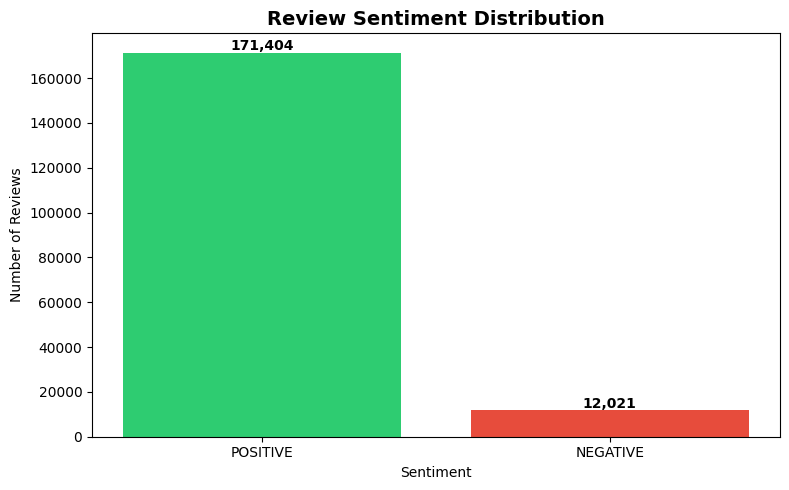

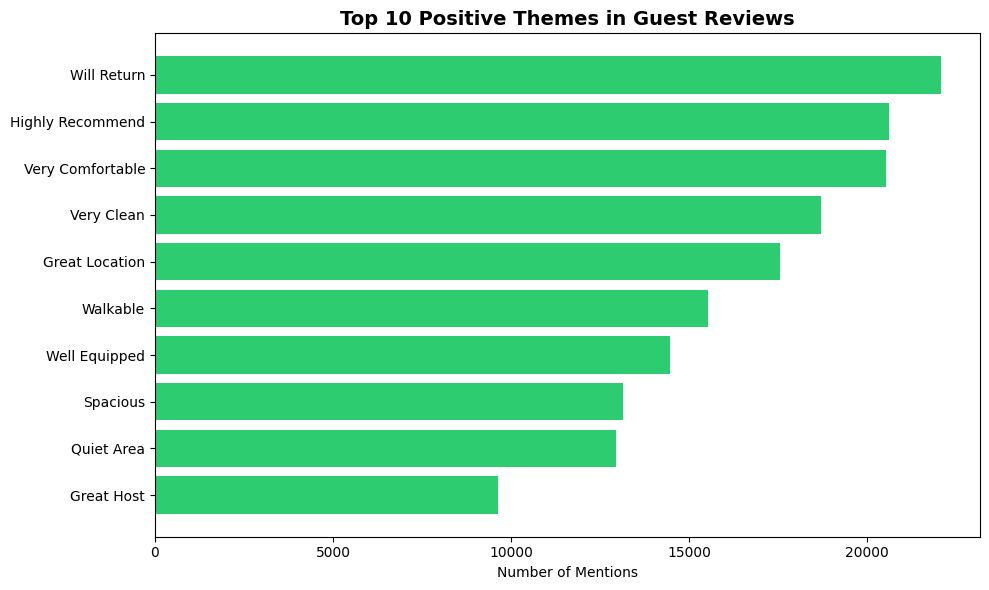

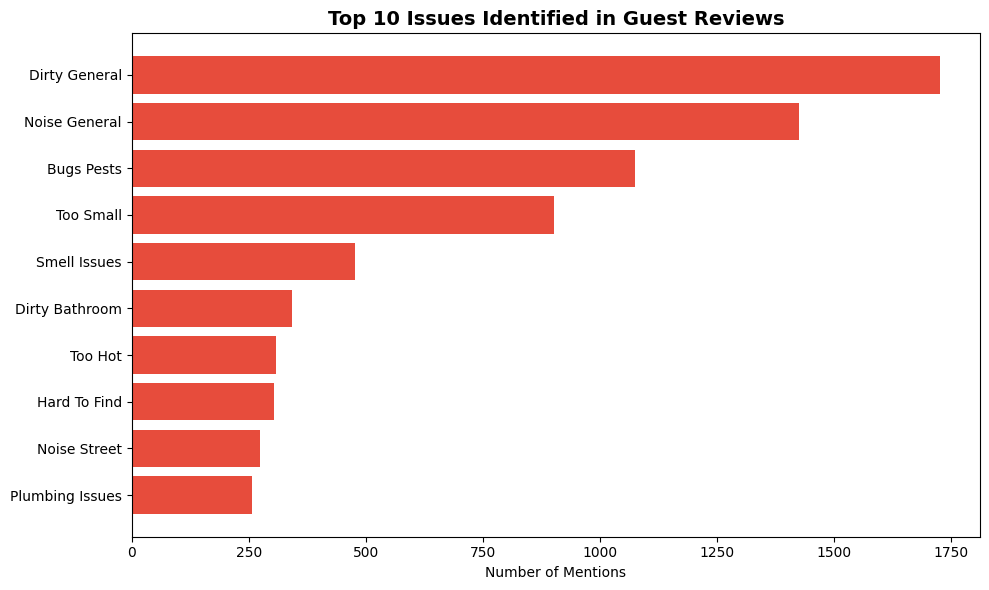

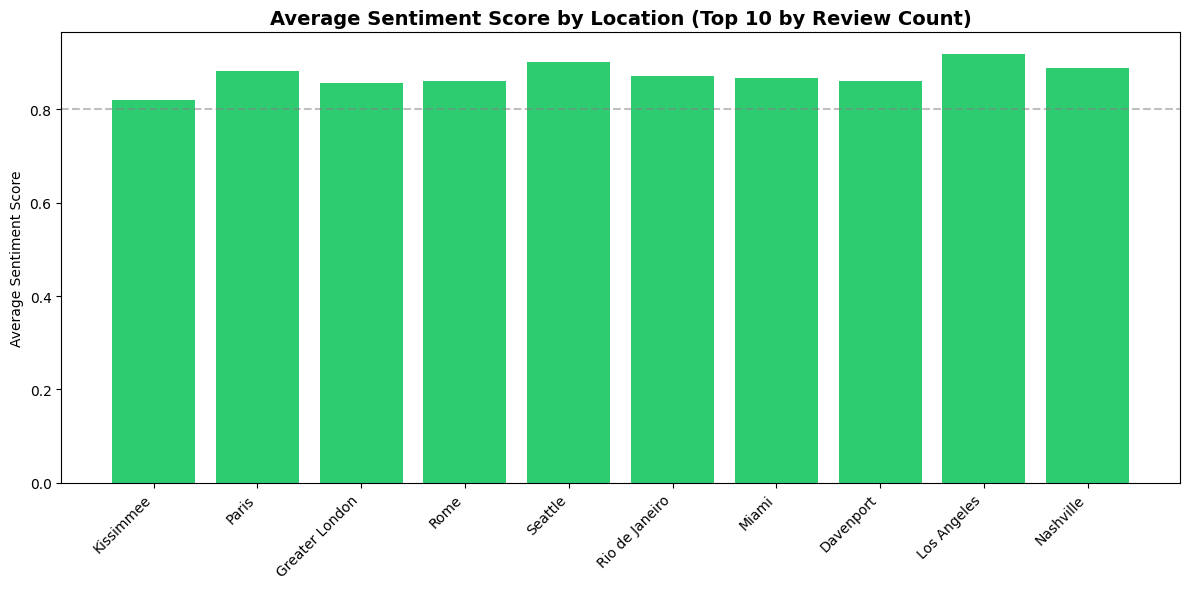

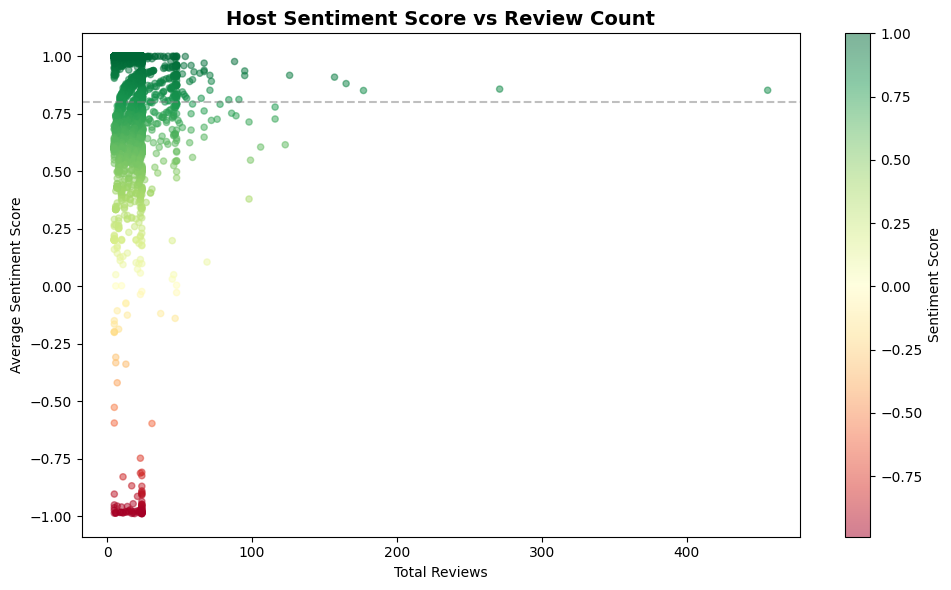

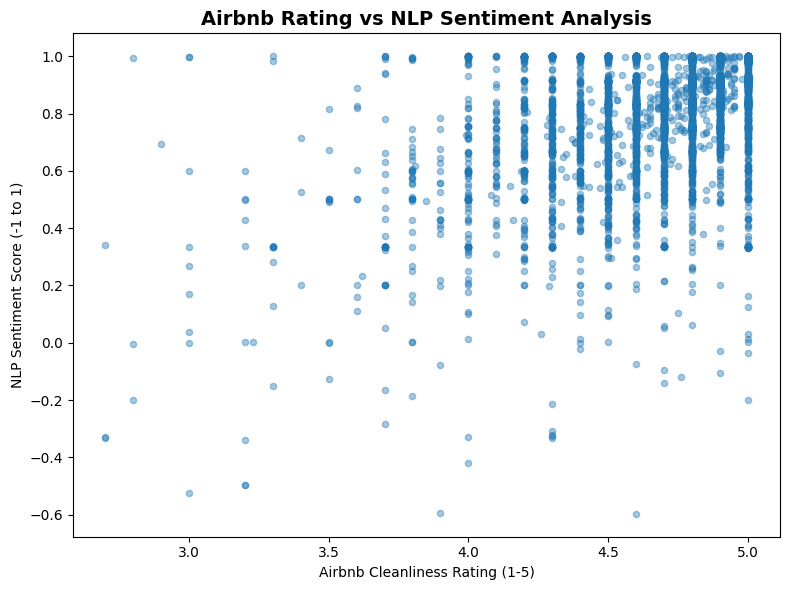

✅ All visualizations saved!


In [0]:
# ============================================
#  VISUALIZATIONS FOR DATABRICKS
# ============================================
import matplotlib.pyplot as plt

# ----- VISUALIZATION 1: Sentiment Distribution -----
fig, ax = plt.subplots(figsize=(8, 5))
sentiment_counts = reviews_exploded['sentiment_label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
ax.set_title('Review Sentiment Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')
for i, v in enumerate(sentiment_counts.values):
    ax.text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('viz_1_sentiment_distribution.png', dpi=150)
plt.show()

# ----- VISUALIZATION 2: Top Positive Themes -----
fig, ax = plt.subplots(figsize=(10, 6))
positive_themes = [t for themes in reviews_exploded['positive_themes'] for t in themes]
pos_counts = Counter(positive_themes).most_common(10)
themes, counts = zip(*pos_counts)
themes = [t.replace('_', ' ').title() for t in themes]
ax.barh(themes[::-1], counts[::-1], color='#2ecc71')
ax.set_title('Top 10 Positive Themes in Guest Reviews', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Mentions')
plt.tight_layout()
plt.savefig('viz_2_positive_themes.png', dpi=150)
plt.show()

# ----- VISUALIZATION 3: Top Negative Issues -----
fig, ax = plt.subplots(figsize=(10, 6))
negative_themes = [t for themes in reviews_exploded['negative_themes'] for t in themes]
neg_counts = Counter(negative_themes).most_common(10)
themes, counts = zip(*neg_counts)
themes = [t.replace('_', ' ').title() for t in themes]
ax.barh(themes[::-1], counts[::-1], color='#e74c3c')
ax.set_title('Top 10 Issues Identified in Guest Reviews', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Mentions')
plt.tight_layout()
plt.savefig('viz_3_negative_issues.png', dpi=150)
plt.show()

# ----- VISUALIZATION 4: Sentiment by Location (Top 10 cities) -----
fig, ax = plt.subplots(figsize=(12, 6))
location_sentiment = reviews_exploded.groupby('location').agg({
    'sentiment_score': 'mean',
    'review_id': 'count'
}).rename(columns={'review_id': 'review_count'})
location_sentiment = location_sentiment[location_sentiment['review_count'] >= 100]
location_sentiment = location_sentiment.sort_values('review_count', ascending=False).head(10)

colors = ['#2ecc71' if x > 0.8 else '#f39c12' if x > 0.7 else '#e74c3c' 
          for x in location_sentiment['sentiment_score']]
ax.bar(range(len(location_sentiment)), location_sentiment['sentiment_score'], color=colors)
ax.set_xticks(range(len(location_sentiment)))
ax.set_xticklabels([loc.split(',')[0] for loc in location_sentiment.index], rotation=45, ha='right')
ax.set_title('Average Sentiment Score by Location (Top 10 by Review Count)', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Sentiment Score')
ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('viz_4_sentiment_by_location.png', dpi=150)
plt.show()

# ----- VISUALIZATION 5: Review Count vs Sentiment -----
fig, ax = plt.subplots(figsize=(10, 6))
host_plot = host_summary[host_summary['total_reviews'] >= 5].copy()
scatter = ax.scatter(host_plot['total_reviews'], host_plot['avg_sentiment_score'], 
                     alpha=0.5, c=host_plot['avg_sentiment_score'], cmap='RdYlGn', s=20)
ax.set_xlabel('Total Reviews')
ax.set_ylabel('Average Sentiment Score')
ax.set_title('Host Sentiment Score vs Review Count', fontsize=14, fontweight='bold')
ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='Good threshold (0.8)')
plt.colorbar(scatter, label='Sentiment Score')
plt.tight_layout()
plt.savefig('viz_5_reviews_vs_sentiment.png', dpi=150)
plt.show()

# ----- VISUALIZATION 6: Airbnb Ratings vs NLP Sentiment -----
fig, ax = plt.subplots(figsize=(8, 6))
valid_data = host_summary[host_summary['avg_cleanliness'].notna()].copy()
ax.scatter(valid_data['avg_cleanliness'], valid_data['avg_sentiment_score'], alpha=0.4, s=20)
ax.set_xlabel('Airbnb Cleanliness Rating (1-5)')
ax.set_ylabel('NLP Sentiment Score (-1 to 1)')
ax.set_title('Airbnb Rating vs NLP Sentiment Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('viz_6_rating_vs_sentiment.png', dpi=150)
plt.show()

print("✅ All visualizations saved!")
